In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from scipy.constants import c as speed_of_light
from tqdm import tqdm
from numba import njit, jit, prange
from numba.typed import List
import time
from scipy.stats import mode
from numba.typed import List

In [3]:
@njit
def calc_flux(wl, flux, wlrange):
    """
    Calculates the flux of a flux density in Jy over a range of wavelengths in microns
    """
    mask = (wl >= wlrange[0]) & (wl <= wlrange[1])
    return total_flux(wl[mask], flux[mask])


@njit
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    if wl.size == 0:
        return 0
    flux_lambda = (speed_of_light * 100 / (wl * 1e-4) ** 2) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux


def compress_to_numpy(model_names, species, df):
    dim1 = len(model_names)
    dim2 = len(species)

    arr = []

    for i, model_name in enumerate(model_names):
        row = []
        for j, species_name in enumerate(species):
            wavelength = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Wavelength'].values[0]
            flux = df.loc[df['Model Name'] == model_name, f'FLiTs {species_name} Flux'].values[0]
            row.append((wavelength, flux))
        arr.append(row)

    numba_list = List()
    for row in arr:
        numba_row = List()
        for item in row:
            numba_row.append(item)
        numba_list.append(numba_row)

    return numba_list


@njit(parallel=True, fastmath=True)
def spectral_window(min_wl, max_wl, window_size, arr):
    windows_array = np.arange(min_wl, max_wl, window_size)
    num_models = len(arr)
    num_windows = len(windows_array)

    dom = np.full((num_models, num_windows), -1, dtype=np.int32)

    # Parallelize the outer loop using prange
    for i in prange(num_models):
        for index_window in range(num_windows):
            window_start = windows_array[index_window]
            window_end = window_start + window_size

            max_flux = -np.inf
            dominant_specie_index = -1

            for j in range(len(arr[i])):
                wavelength, flux = arr[i][j]

                flux_value = calc_flux(wavelength, flux, [window_start, window_end])

                if flux_value > max_flux:
                    max_flux = flux_value
                    dominant_specie_index = j

            dom[i, index_window] = dominant_specie_index

    return windows_array, dom

In [4]:
# Open the data 
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)
# df.head()

In [5]:
model_names = np.array(df['Model Name'])
species = ['atomic', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
min_wl = 4.9
max_wl = 28.6
window_size = .01

arr = compress_to_numpy(model_names, species, df)
start_time = time.time()
windows, dominant = spectral_window(min_wl, max_wl, window_size, arr)
end_time = time.time()
print(f'time taken for computation:{end_time - start_time:.1f}')

C:\Users\Niels de Klerk\AppData\Local\Temp\ipykernel_5048\2986252985.py:63: NumbaTypeSafetyWarning: unsafe cast from uint64 to int64. Precision may be lost.
  for j in range(len(arr[i])):


time taken for computation:40.9


['atomic', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'OH']


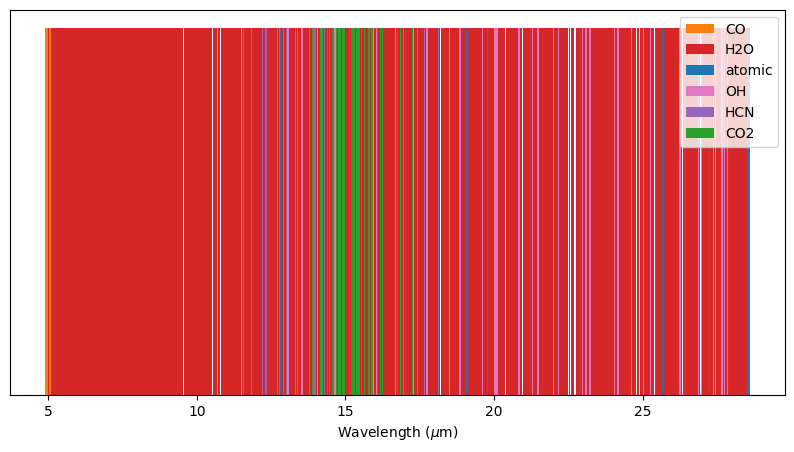

In [8]:
majority_values = mode(dominant, axis=0).mode
print([species[i] for i in np.unique(majority_values)])
colors = plt.colormaps["tab10"].colors[:len(np.unique(majority_values))]
name_colors = dict(zip(np.unique(majority_values), colors))
new_species = species + ['Different']

plt.figure(figsize=(10, 5))
for i in range(len(windows)):
    if new_species[majority_values[i]] != 'NH3':
        plt.bar(windows[i], 1, width=window_size, color=name_colors[majority_values[i]], label=new_species[majority_values[i]])

handles, labels = plt.gca().get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
plt.legend(unique_labels.values(), unique_labels.keys())
plt.xlabel(r'Wavelength ($\mu$m)')
plt.yticks([])

# plt.xlim(4.9, 5.2)
plt.savefig('Spectral_regions.pdf')
plt.show()